# Tissue Phenotyping using KRONOS Embedding
KRONOS embedding can be used to cluster tissue into different regions/phenotypes which can then be used for patient prognostication or stratification.

## Prerequisites

To follow this tutorial, ensure you have the following data prepared:

1. **Multiplex Images**: TIFF images with multiple markers (e.g., DAPI, CD markers, etc.).
2. **Marker Metadata**: A CSV file containing the following columns:
    - `channel_id`: Identifier for the image channel.
    - `marker_name`: Name of the marker (e.g., DAPI, CD20).
    - `marker_id`: Unique ID for the marker.
    - `marker_mean`: Mean intensity value for normalization.
    - `marker_std`: Standard deviation for normalization.


**Notes**: Refer to the **[1-Data-Download-And-Preprocessing](https://github.com/mahmoodlab/KRONOS/blob/main/tutorials/1%20-%20Data-Download-And-Preprocessing.ipynb)** tutorial to prepare data.
 

## Step 1: Import Required Packages

We begin by importing the necessary libraries and modules for the workflow.

In [1]:
import warnings
import numpy as np
import pandas as pd
import skimage.io as skio
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
import torch
from kronos import create_model_from_pretrained

## Experiment Configuration

In [2]:
# Define the root directory for the project
project_dir = "./chl_maps_dataset"  # Replace with your actual project directory

# Configuration dictionary containing all parameters for the pipeline
config = {
    "multiplex_image_path": f"{project_dir}/dataset/multiplex_images/image_01.tiff",
    "marker_info_with_metadata_csv_path": f"{project_dir}/dataset/marker_info_with_metadata.csv", # Path to the marker metadata CSV file
    "results_dir": f"{project_dir}/results/",
    
    # Model-related parameters
    "checkpoint_path": "hf_hub:MahmoodLab/kronos",  # Path to the pre-trained model checkpoint (local or Hugging Face Hub)
    "hf_auth_token": None,  # Authentication token for Hugging Face Hub (if checkpoint is from the Hub)
    "cache_dir": f"{project_dir}/models/",  # Directory to cache KRONOS model if downloading from Hugging Face Hub
    "model_type": "vits16",  # Type of pre-trained model to use (e.g., vits16)
    "token_overlap": False,  # Whether to use token overlap during feature extraction
    
    "patch_size": 64, # Size of the patches to be extracted from the multiplex image
    "stride_size" : 32, # Stride size for the sliding window approach 
    "batch_size": 32, # Batch size for processing patches through the model
    "n_clusters": 20, # Number of clusters for clustering
}

## Load Image

In [3]:
img = skio.imread(config["multiplex_image_path"])
img = img/np.iinfo(img.dtype).max

print("Image shape (n_markers, height, width): ", img.shape)

Image shape (n_markers, height, width):  (49, 8011, 8085)


## Load Marker Metadata

In [4]:
marker_metadata = pd.read_csv(config["marker_info_with_metadata_csv_path"])
marker_metadata.set_index("marker_name", inplace=True)
display(marker_metadata)

,channel_id,marker_id,marker_mean,marker_std
marker_name,,,,
BCL-2,0,150,0.047104,0.060276
CCR6,1,166,0.044867,0.042833
CD11B,2,180,0.032169,0.052366
CD11C,3,182,0.019039,0.044336
CD15,4,194,0.016322,0.040416
CD16,5,196,0.041869,0.055626
CD162,6,198,0.012217,0.040094
CD163,7,200,0.014384,0.033087
CD2,8,212,0.161256,0.110404


## Select Markers of Interest for Tissue Phenotyping

In [5]:
marker_names = ['DAPI-01', 'CD11B', 'CD11C', 'CD15', 'CD163', 'CD20', 'CD206', 'CD30', 'CD31', 'CD4', 'CD56', 'CD68', 'CD7', 'CD8', 'CYTOKERITIN', 'FOXP3', 'MCT', 'PODOPLANIN']
        
marker_img = img[[marker_metadata.loc[marker_name]["channel_id"].astype(int) for marker_name in marker_names]]
marker_mean = np.array([marker_metadata.loc[marker_name]["marker_mean"] for marker_name in marker_names])
marker_std = np.array([marker_metadata.loc[marker_name]["marker_std"] for marker_name in marker_names])
marker_ids = [marker_metadata.loc[marker_name]["marker_id"].astype(np.int64) for marker_name in marker_names]
print("Image shape (n_markers, height, width): ", marker_img.shape)

Image shape (n_markers, height, width):  (18, 8011, 8085)


## Normalize Image

In [6]:
if np.max(marker_img) > 1:
    marker_img = marker_img / np.iinfo(marker_img.dtype).max # converting image from 0-65535 to 0-1

# normalizing the image using markser specific mean and std values
marker_img = (marker_img - marker_mean[:, None, None]) / marker_std[:, None, None]

## Load KRONOS Model

In [7]:
# Use the KRONOS library to create a model from a pre-trained checkpoint
model, precision, embedding_dim = create_model_from_pretrained(
    checkpoint_path=config["checkpoint_path"],  # Path to the model checkpoint
    cfg_path=None,  # Configuration path (not used here)
    hf_auth_token=config["hf_auth_token"],  # Hugging Face authentication token
    cache_dir=config["cache_dir"],  # Directory to cache the model
    cfg={
        "model_type": config["model_type"],  # Type of model (e.g., ViT-S16)
        "token_overlap": config["token_overlap"]  # Whether to use token overlap
    },
)

Loaded model weights from ./chl_maps_dataset/models/models--MahmoodLab--kronos/snapshots/3a0bb4ad91c212a0a818ffc9235c158927ef2b27/kronos_vits16_model.pt


## Patch Extraction

In [8]:
patches = []
coords = []
patch_size = config["patch_size"]
stride_size = config["stride_size"]
for i in range(0, marker_img.shape[1] - patch_size + 1, stride_size):
    for j in range(0, marker_img.shape[2] - patch_size + 1, stride_size):
        patches.append(marker_img[:, i:i+patch_size, j:j+patch_size])
        coords.append((i, j))
print("Number of patches: ", len(patches))

Number of patches:  62499


## Feature Extraction

In [9]:
batch_size = config["batch_size"]
patch_features_list = []
marker_features_list = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
for i in range(0, len(patches), batch_size):
    print(f"Processing batch {i//batch_size+1}/{len(patches)//batch_size+1}", end="\r") 
    if (i+batch_size) > len(patches):
        batch = patches[i:]
    else:
        batch = patches[i:i+batch_size]
    batch = torch.tensor(np.array(batch), device=device, dtype=torch.float32)
    batch_marker_ids = [torch.tensor(marker_ids, device=device) for _ in range(batch.shape[0])]
    with torch.no_grad():
        patch_features, marker_features, _  = model(batch, marker_ids=batch_marker_ids)
    patch_features_list.extend(patch_features.cpu().numpy())
    marker_features_list.extend(marker_features.cpu().numpy())
patch_features = np.array(patch_features_list)
marker_features = np.array(marker_features_list)
print("Patch features shape: ", patch_features.shape)
print("Marker features shape: ", marker_features.shape)

Patch features shape:  (62499, 384)
Marker features shape:  (62499, 18, 384)


## Phenotyping
While any appropriate clustering method for tissue phenotyping can be used, here we used KMeans as it is computationally efficient and performs robustly on Kronos embeddings.

In [10]:
kmeans = KMeans(n_clusters=config["n_clusters"], random_state=0)

labels = kmeans.fit_predict(marker_features.reshape(marker_features.shape[0], -1))
cluster_map = np.zeros((marker_img.shape[1], marker_img.shape[2]), dtype=np.uint8)
for i, (x, y) in enumerate(coords):
    cluster_map[x:x+patch_size, y:y+patch_size] = labels[i]

## Visualize Clustering Results along with Multiplex Image

In [11]:
def get_rgb_image(multiplex_image, colors):
    multiplex_image = multiplex_image.astype(np.float32)
    # Normalize each channel individually
    for i in range(multiplex_image.shape[-1]):
        min_val, max_val = multiplex_image[..., i].min(), multiplex_image[..., i].max()
        if max_val > min_val:
            multiplex_image[..., i] = (multiplex_image[..., i] - min_val) / (max_val - min_val)

    # Compute the weighted sum of colors
    multiplex_image = np.tensordot(multiplex_image*2, colors, axes=([2], [0]))
    multiplex_image = np.clip(multiplex_image, 0, 255).astype(np.uint8)
    return multiplex_image

colors = np.array([
    [0, 0, 255],    # Blue
    [255, 0, 0],    # Red 
    [0, 255, 0],    # Green 
    [255, 255, 0],  # Yellow 
    [255, 0, 255],  # Magenta 
    [0, 255, 255],  # Cyan 
], dtype=np.float32)
color_list = ['Blue', 'Red', 'Green', 'Yellow', 'Magenta', 'Cyan']
marker_set_1 = ['DAPI-01', 'CD11B', 'CD11C', 'CD15', 'CD163', 'CD20']
marker_set_2 = ['DAPI-01', 'CD206', 'CD30', 'CD31', 'CD4', 'CD56']
marker_set_3 = ['DAPI-01', 'CD7', 'CD8', 'CYTOKERITIN', 'FOXP3', 'PODOPLANIN']

multiplex_image_1 = np.stack([img[marker_metadata.loc[marker_name]["channel_id"].astype(int), :, :] for marker_name in marker_set_1], axis=-1)
multiplex_image_2 = np.stack([img[marker_metadata.loc[marker_name]["channel_id"].astype(int), :, :] for marker_name in marker_set_2], axis=-1)
multiplex_image_3 = np.stack([img[marker_metadata.loc[marker_name]["channel_id"].astype(int), :, :] for marker_name in marker_set_3], axis=-1)

multiplex_image_1 = get_rgb_image(multiplex_image_1, colors)
multiplex_image_2 = get_rgb_image(multiplex_image_2, colors)
multiplex_image_3 = get_rgb_image(multiplex_image_3, colors)

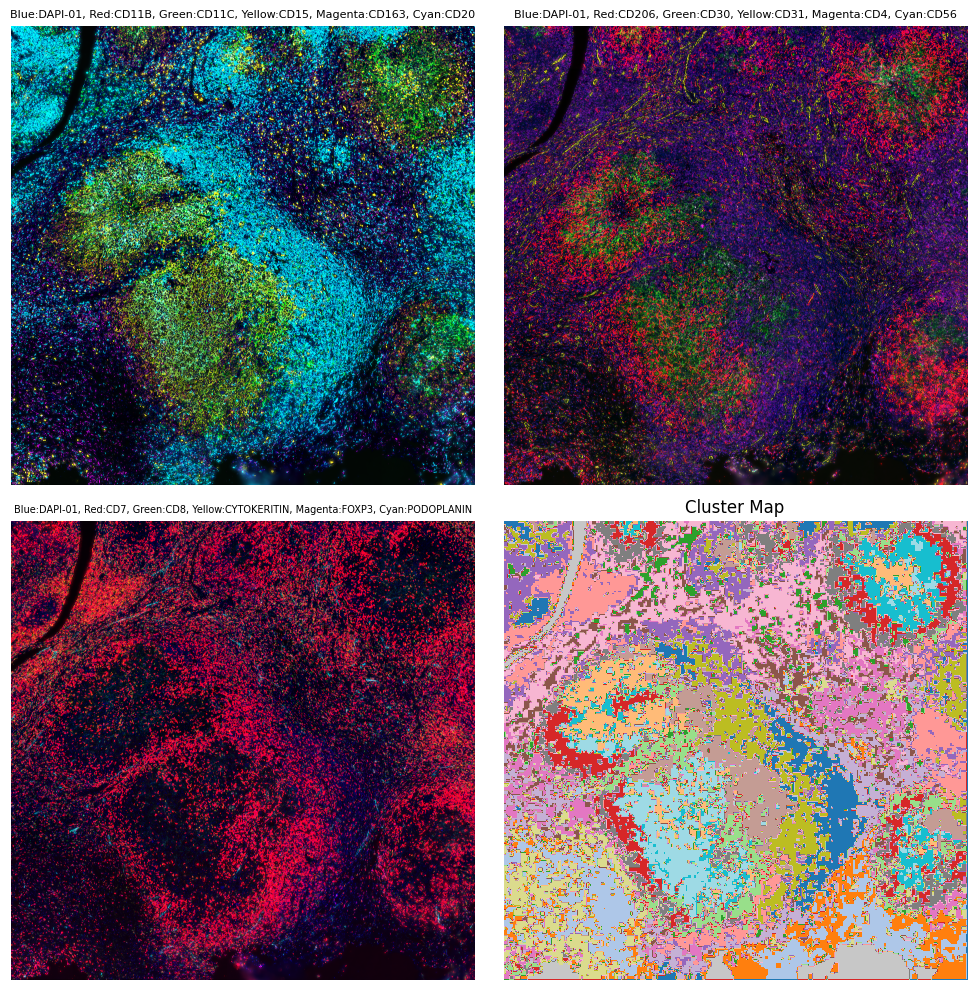

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].set_title(", ".join([color_name+":"+marker_name for color_name, marker_name in zip(color_list, marker_set_1)]), fontsize=8)
ax[0, 0].imshow(multiplex_image_1)
ax[0, 0].axis('off')
ax[0, 1].set_title(", ".join([color_name+":"+marker_name for color_name, marker_name in zip(color_list, marker_set_2)]), fontsize=8)
ax[0, 1].imshow(multiplex_image_2)
ax[0, 1].axis('off')
ax[1, 0].set_title(", ".join([color_name+":"+marker_name for color_name, marker_name in zip(color_list, marker_set_3)]), fontsize=7)
ax[1, 0].imshow(multiplex_image_3)
ax[1, 0].axis('off')
ax[1, 1].set_title("Cluster Map")
ax[1, 1].imshow(cluster_map, cmap='tab20')
ax[1, 1].axis('off')
plt.tight_layout()
plt.show()